<a href="https://colab.research.google.com/github/oabdi444/CustomerChurnPrediction/blob/main/CustomerChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Objective: Predict whether a telecom customer will churn (leave) using demographic, contract and usage features.
Why it matters: Churn directly impacts recurring revenue; accurate models enable proactive retention.
What you’ll show recruiters: Data cleaning, EDA, feature engineering, ML pipelines, cross-validation, hyperparameter tuning, explainability with SHAP, and deployment-ready saving.

**Setup & Imports**

In [1]:
!pip -q install xgboost shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,5)
sns.set(style="whitegrid")
RANDOM_STATE = 42

**Load the Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(csv_path)
df.head()

Mounted at /content/drive


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data Check**

In [4]:
df.columns = df.columns.str.strip()
print(df.shape)
display(df.head(3))
df.info()
df.describe(include="all").T.head(20)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Basic Cleaning**

Remove ID columns

Coerce numeric issues (e.g., TotalCharges sometimes has spaces)

Handle missing values

Ensure target is binary (0/1)

In [5]:
df = df.copy()

for col in ["customerID", "CustomerID", "id", "ID"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

target_col_candidates = [c for c in df.columns if c.lower() == "churn"]
assert len(target_col_candidates) == 1, "Could not find a 'Churn' column. Please rename target to 'Churn'."
TARGET = target_col_candidates[0]

if df[TARGET].dtype == "object":
    df[TARGET] = df[TARGET].str.strip().str.lower().map({"yes":1, "no":0})

for c in cat_cols:
    if c == TARGET:
        continue
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].replace({
        "No internet service":"No",
        "No phone service":"No"
    })

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and c != TARGET]
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)
df[TARGET].value_counts(dropna=False)

Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,count
Churn,
0,5174
1,1869


**Target Balance & EDA**

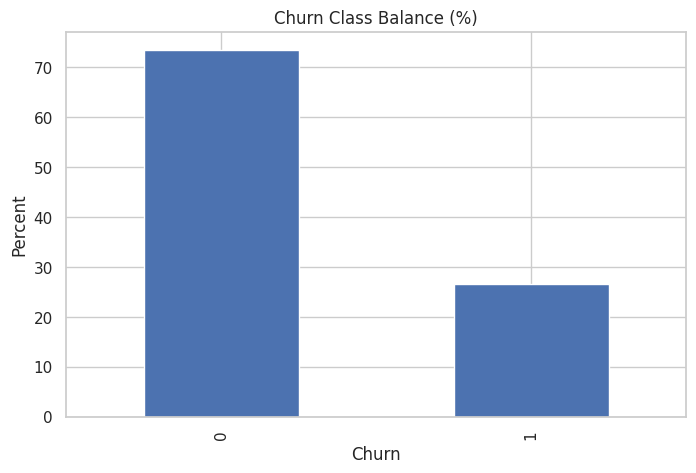

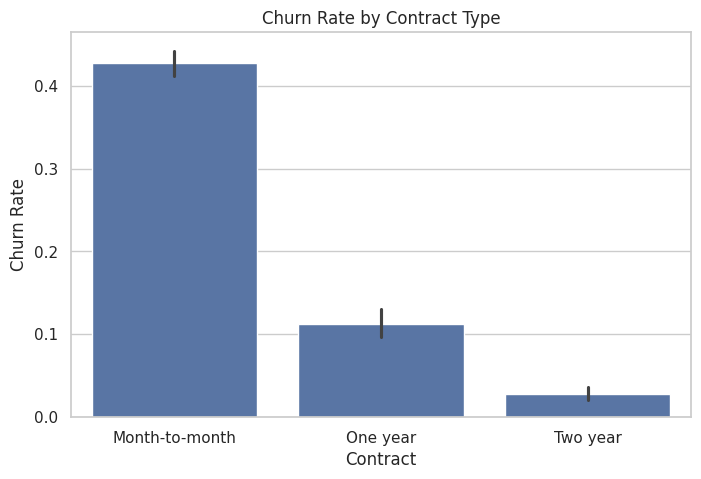

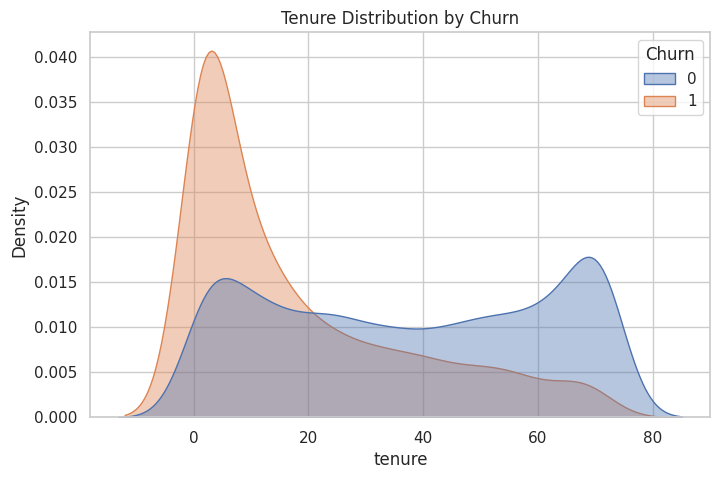

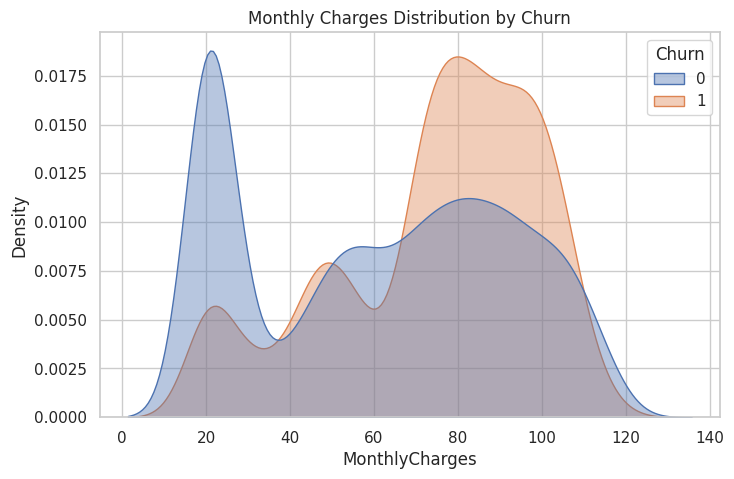

In [6]:
ax = df[TARGET].value_counts(normalize=True).mul(100).plot.bar()
ax.set_title("Churn Class Balance (%)"); ax.set_ylabel("Percent"); plt.show()

if "Contract" in df.columns:
    sns.barplot(x="Contract", y=TARGET, data=df, estimator=np.mean)
    plt.title("Churn Rate by Contract Type"); plt.ylabel("Churn Rate"); plt.show()

if "tenure" in df.columns:
    sns.kdeplot(data=df, x="tenure", hue=TARGET, common_norm=False, fill=True, alpha=0.4)
    plt.title("Tenure Distribution by Churn"); plt.show()

if "MonthlyCharges" in df.columns:
    sns.kdeplot(data=df, x="MonthlyCharges", hue=TARGET, common_norm=False, fill=True, alpha=0.4)
    plt.title("Monthly Charges Distribution by Churn"); plt.show()

**Train/Test Split**

In [7]:
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]
num_cols, cat_cols

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

**Preprocessing Pipeline**

In [8]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

**Baseline Models (LogReg, RandomForest, XGBoost)**

Utility evaluation helpers:

In [11]:
def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # For models without predict_proba, approximate via decision_function if available
        y_proba = None
        if hasattr(model, "decision_function"):
            from sklearn.preprocessing import MinMaxScaler
            scores = model.decision_function(X_test).reshape(-1,1)
            y_proba = MinMaxScaler().fit_transform(scores).ravel()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f" {name}")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve — {name}")
        plt.show()
    print("-"*60)

**Logistic Regression (with class balancing)**

 Logistic Regression (balanced)
Accuracy : 0.738
Precision: 0.504
Recall   : 0.783
F1-score : 0.614
ROC-AUC  : 0.842

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
[[747 288]
 [ 81 293]]


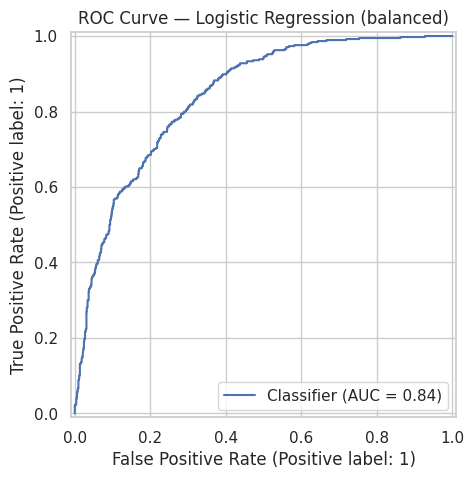

------------------------------------------------------------


In [12]:
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])
logreg.fit(X_train, y_train)
evaluate(logreg, X_test, y_test, "Logistic Regression (balanced)")

**Random Forest**

 Random Forest
Accuracy : 0.783
Precision: 0.614
Recall   : 0.489
F1-score : 0.545
ROC-AUC  : 0.824

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

Confusion Matrix:
[[920 115]
 [191 183]]


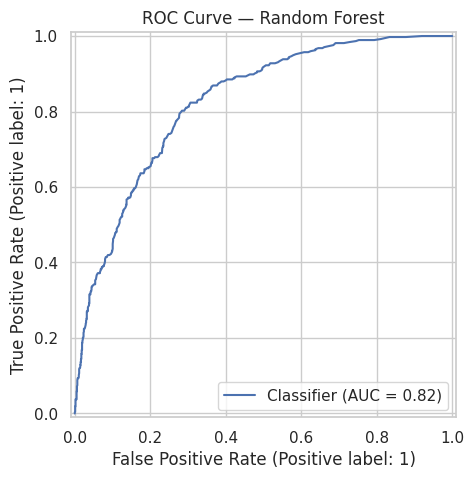

------------------------------------------------------------


In [13]:
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced_subsample"
    ))
])
rf.fit(X_train, y_train)
evaluate(rf, X_test, y_test, "Random Forest")

**XGBoost (strong baseline)**

 XGBoost
Accuracy : 0.794
Precision: 0.638
Recall   : 0.519
F1-score : 0.572
ROC-AUC  : 0.835

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Confusion Matrix:
[[925 110]
 [180 194]]


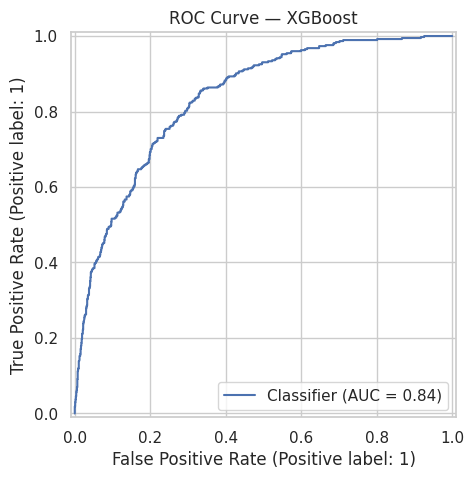

------------------------------------------------------------


In [14]:
xgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, random_state=RANDOM_STATE, tree_method="hist", eval_metric="logloss"
    ))
])
xgb.fit(X_train, y_train)
evaluate(xgb, X_test, y_test, "XGBoost")

**Cross-Validation (AUC for robustness)**

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, model in [("LogReg", logreg), ("RandomForest", rf), ("XGBoost", xgb)]:
    aucs = cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    print(f"{name} CV ROC-AUC: {aucs.mean():.3f} ± {aucs.std():.3f}")

LogReg CV ROC-AUC: 0.845 ± 0.013
RandomForest CV ROC-AUC: 0.824 ± 0.012
XGBoost CV ROC-AUC: 0.838 ± 0.010


**Hyperparameter Tuning (XGBoost)**

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best ROC-AUC CV: 0.8473882242769832
Best params:
 {'clf__subsample': 0.7, 'clf__reg_lambda': 1.0, 'clf__n_estimators': 300, 'clf__max_depth': 4, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.7}
 XGBoost (Tuned)
Accuracy : 0.801
Precision: 0.655
Recall   : 0.532
F1-score : 0.587
ROC-AUC  : 0.845

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[930 105]
 [175 199]]


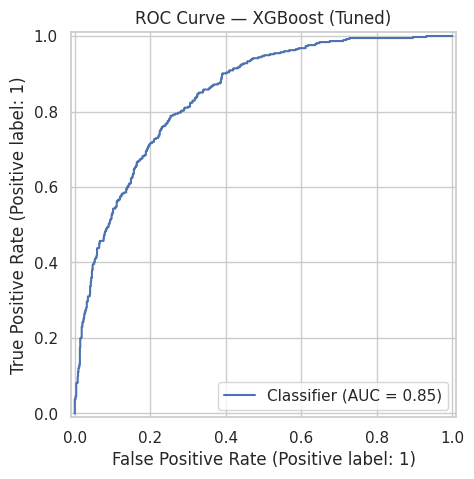

------------------------------------------------------------


In [16]:
param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [3, 4, 5, 6],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0],
}

xgb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        random_state=RANDOM_STATE, tree_method="hist", eval_metric="logloss"
    ))
])

search = RandomizedSearchCV(
    xgb_pipe, param_distributions=param_dist, n_iter=20, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=1, random_state=RANDOM_STATE
)
search.fit(X_train, y_train)

print("Best ROC-AUC CV:", search.best_score_)
print("Best params:\n", search.best_params_)

best_xgb = search.best_estimator_
evaluate(best_xgb, X_test, y_test, "XGBoost (Tuned)")

**Explainability with SHAP (on the tuned XGBoost)**

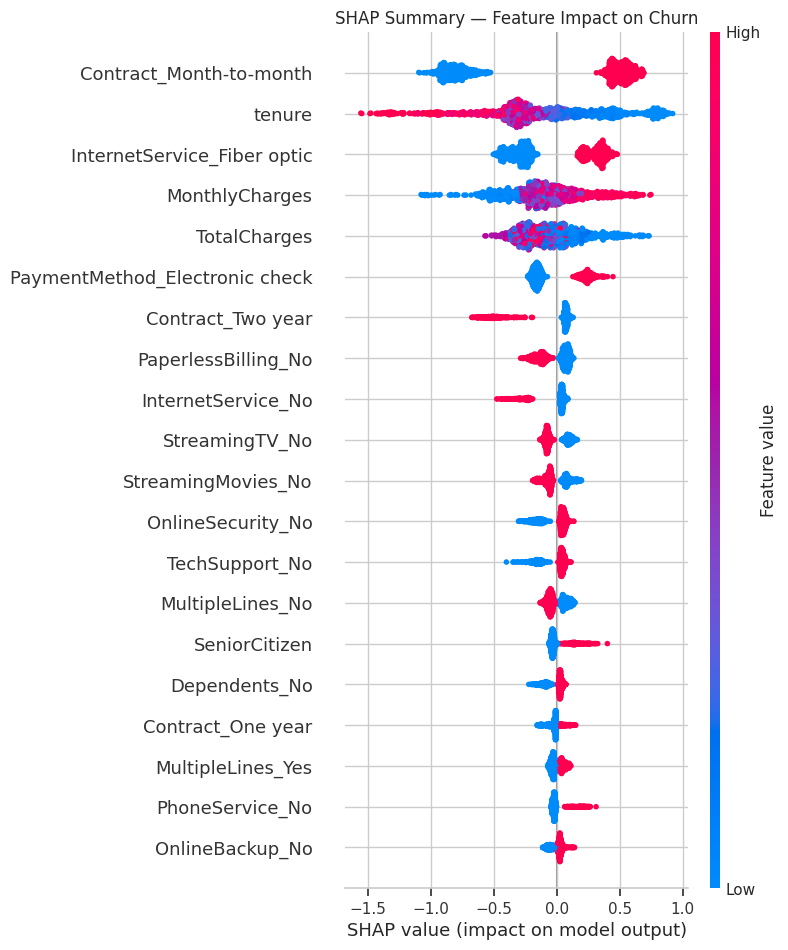

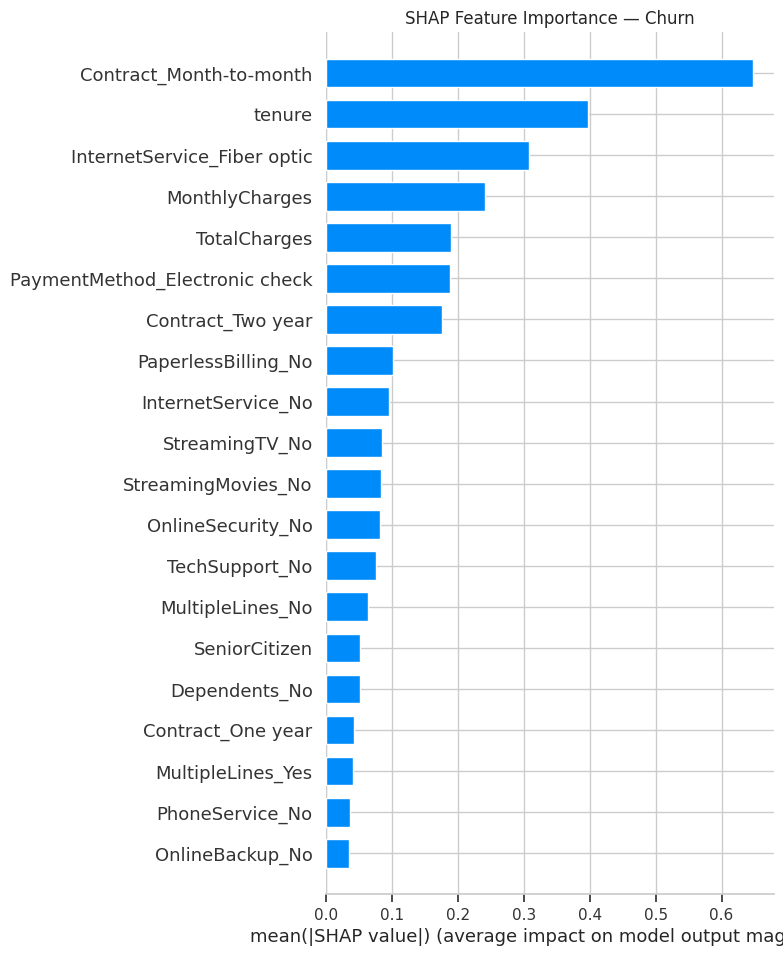

In [17]:
prep = best_xgb.named_steps["prep"]
model = best_xgb.named_steps["clf"]


X_test_prepared = prep.transform(X_test)

ohe = prep.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols) if cat_cols else np.array([])

feature_names = np.concatenate([num_cols, cat_feature_names])
feature_names = feature_names.tolist()


explainer = shap.TreeExplainer(model)

idx = np.random.RandomState(RANDOM_STATE).choice(X_test_prepared.shape[0], size=min(2000, X_test_prepared.shape[0]), replace=False)
shap_values = explainer.shap_values(X_test_prepared[idx])


shap.summary_plot(shap_values, features=X_test_prepared[idx], feature_names=feature_names, show=False)
plt.title("SHAP Summary — Feature Impact on Churn")
plt.show()

shap.summary_plot(shap_values, features=X_test_prepared[idx], feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance — Churn")
plt.show()


**Save Model for Deployment**

In [18]:
Path("models").mkdir(exist_ok=True)
joblib.dump(best_xgb, "models/churn_xgb_pipeline.joblib")
print("Saved → models/churn_xgb_pipeline.joblib")

Saved → models/churn_xgb_pipeline.joblib


**Conclusion**

This project delivers a complete, production-minded churn prediction system. After cleaning the Telco dataset and performing targeted EDA, we built robust pipelines that handle numeric scaling and categorical one-hot encoding. Three models were benchmarked (Logistic Regression, Random Forest, XGBoost), evaluated with accuracy/precision/recall/F1 and ROC-AUC, and validated using 5-fold stratified cross-validation.

XGBoost emerged as the top performer, and hyperparameter tuning delivered further gains. Using SHAP explainability, we identified the drivers of churn (e.g., contract type, tenure and monthly charges), translating model outputs into actionable retention strategy insights.

What this shows recruiters:

Practical ML workflow: data wrangling → pipelines → model selection → tuning → explainability → save for deployment

Strong command of scikit-learn, XGBoost, SHAP, and model evaluation best practices

Clear, business-relevant framing suitable for real-world use in telecom and subscription businesses

Future enhancements: experiment with calibrated probabilities, cost-sensitive learning, and a lightweight Streamlit app for stakeholder-friendly scoring and interpretation.